In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
class TrainDataset(Dataset):
    def __init__(self, train_file, transform=None):
        self.data = pd.read_csv(train_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        if transform is not None:
            self.data = self.transform(np.array(self.data))

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        user_vector = self.data.data[0][ind]
        return user_vector

In [3]:
class TestDataset(Dataset):
    def __init__(self, test_file, transform=None):
        self.data = pd.read_csv(test_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        if transform is not None:
            self.data = self.transform(np.array(self.data))

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        user_vector = self.data.data[0][ind]
        return user_vector

In [4]:
def prepare_train_validation_movielens_step1():
    rat = pd.read_csv('ratings.csv')
    mov = pd.read_csv('movies.csv')
    df_combined = pd.merge(rat, mov, on = 'movieId')
    print(rat.describe())
    ts = rat['timestamp'].quantile(0.98)
    train_ratings = pd.DataFrame(columns=['userId','movieId','rating'])
    validation_ratings = pd.DataFrame(columns=['userId','movieId','rating'])
    for i in range(len(rat)):
        if rat['timestamp'].iloc[i] <= ts:
            train_ratings = pd.concat([train_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat ['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])
            validation_ratings = pd.concat([validation_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])
        else:
            validation_ratings = pd.concat([validation_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])
        if i%10000 == 0:
            print(i, "Completed")
    print(len(train_ratings))
    print(len(validation_ratings))
    # Remove users in validation set those are not present in Training Set
    train_users = train_ratings['userId'].unique()
    users_not_in_train_set = []

    for i in range(1,611):
        if i in train_users:
            continue
        else:
            users_not_in_train_set.append(i)

    for i in users_not_in_train_set:
        validation_ratings = validation_ratings[validation_ratings['userId']!=i]

    validation_ratings.reset_index(drop=True)

    print(len(train_ratings['movieId'].unique()))
    print(len(validation_ratings['movieId'].unique()))
    # Remove Movies that are not in the Train Set
    validation_movies = validation_ratings['movieId'].unique()
    train_movies = train_ratings['movieId'].unique()
    movies_not_in_train_set = []

    for i in validation_movies:
        if i in train_movies:
            continue
        else:
            movies_not_in_train_set.append(i)

    for i in movies_not_in_train_set:
        validation_ratings = validation_ratings[validation_ratings['movieId']!=i]

    validation_ratings.reset_index(drop=True)
    print('Train Users: ', train_ratings['userId'].nunique())
    print('Validation Users: ',validation_ratings['userId'].nunique())
    print('Train Movies: ',train_ratings['movieId'].nunique())
    print('Validation Movies: ',validation_ratings['movieId'].nunique())
    train_ratings.to_csv("train_ratings.csv")
    validation_ratings.to_csv("validation_ratings.csv")


In [5]:
def prepare_traintest_movielens_step2():
    tr_ratings = pd.read_csv('train_ratings.csv')
    val_ratings = pd.read_csv('validation_ratings.csv')
    train_dataset = tr_ratings.pivot_table(index = 'userId', columns = 'movieId', values = 'rating')
    train_dataset.fillna(0, inplace=True)
    print(train_dataset.head(10))
    test_dataset = val_ratings.pivot_table(index='userId', columns='movieId', values='rating')
    test_dataset.fillna(0, inplace=True)
    print(test_dataset.head(10))
    train_dataset.to_csv('train.csv')
    test_dataset.to_csv('test.csv')

In [6]:
def get_traintestloaders():
    transformations = transforms.Compose([transforms.ToTensor()])
    train_dat = TrainDataset('train.csv', transformations)
    test_dat = TestDataset('test.csv', transformations)
    train_loader = DataLoader(dataset=train_dat, batch_size = 128, shuffle=True, num_workers = 1)
    test_loader = DataLoader(dataset=test_dat, batch_size=128, shuffle=True, num_workers=1)
    return train_loader, test_loader

In [7]:
class MSELoss_with_Mask(nn.Module):
    def __init__(self):
        super(MSELoss_with_Mask,self).__init__()

    def forward(self,inputs, targets):
        # Masking into a vector of 1's and 0's.
        mask = (targets!=0)
        mask = mask.float()
        # Actual number of ratings.
        # Take max to avoid division by zero while calculating loss.
        other = torch.Tensor([1.0])
        other = other.cuda()
        number_ratings = torch.max(torch.sum(mask),other)
        error = torch.sum(torch.mul(mask,torch.mul((targets-inputs),(targets-inputs))))
        loss = error.div(number_ratings)
        return loss[0]

In [8]:
import torch.nn.functional as F
import torch.nn.init as init

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(9559, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 9559)
        )

    def encode(self,x):
       
        x = self.encoder(x)
        return x
    def decode(self,x):
        
        x = self.decoder(x)
        return x

    def forward(self,x):
        # Forward Pass
        return self.decode(self.encode(x))

In [10]:
import torch.optim as optim

In [11]:
def train(model, criterion, optimizer, train_dl, test_dl, num_epochs=50):
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for inputs in train_dl:
            inputs = inputs.float().cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_dl)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs in test_dl:
                inputs = inputs.float().cuda()
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_dl)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    return train_losses, val_losses

In [12]:
def main():
    prepare_train_validation_movielens_step1()
    prepare_traintest_movielens_step2()
    train_loader, test_loader = get_traintestloaders()
    #encoder_layers_sizes = [9559, 512, 512, 1024]
    model = AutoEncoder()
    model = model.cuda()
    criterion = MSELoss_with_Mask()
    criterion = criterion.cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses = train(model, criterion, optimizer, train_loader, test_loader, 40)
    # Plot the loss function for both the training and validation
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()
    pass

              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09
0 Completed


<ipython-input-4-8af61a72a507>:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_ratings = pd.concat([train_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat ['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])
<ipython-input-4-8af61a72a507>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  validation_ratings = pd.concat([validation_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])


10000 Completed
20000 Completed
30000 Completed
40000 Completed
50000 Completed
60000 Completed
70000 Completed
80000 Completed
90000 Completed
100000 Completed
98819
100836
9559
9608
Train Users:  595
Validation Users:  595
Train Movies:  9559
Validation Movies:  9559
movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6           0.0     4.0     5.0     3.0     5.0     4.0     4.0     3.0   
7           4.5     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
8           0.0     4.0     0.0     0.0     0.0     0.0

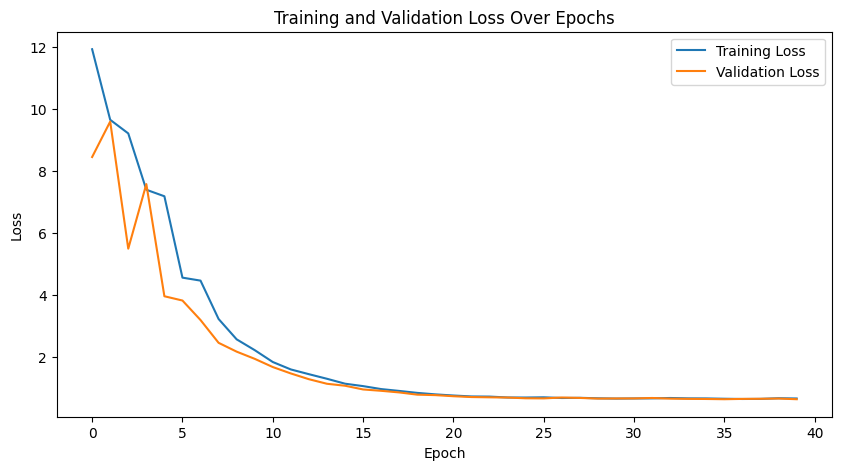

In [15]:
if __name__ == '__main__':
    main()
    pass